In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("sample_data/MerchData.zip", 'r')
zip_ref.extractall("/")
zip_ref.close()

In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
dir="/MerchData"
#creating train and validation sets
BATCH_SIZE = 1
IMG_SIZE = (227, 227)
train_dataset = tf.keras.utils.image_dataset_from_directory(dir,
                                                            validation_split=0.3,
                                                            subset='training',
                                                            shuffle=True,
                                                            seed=2024,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(dir,
                                                            subset='validation',
                                                            validation_split=0.3,
                                                            shuffle=True,
                                                            seed=2024,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

class_names=train_dataset.class_names
print("class names: \n", class_names)

#taking 20% of validation set to make test set
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 3)
val_dataset = val_dataset.skip(val_batches // 3)

Found 75 files belonging to 5 classes.
Using 53 files for training.
Found 75 files belonging to 5 classes.
Using 22 files for validation.
class names: 
 ['MathWorks Cap', 'MathWorks Cube', 'MathWorks Playing Cards', 'MathWorks Screwdriver', 'MathWorks Torch']


In [ ]:
#defining prefech buffers to reduce data fetching time
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#VGG-19----------------------------------------------------------------------------------------------

In [ ]:
#augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
#pre-processing input
preprocess_input = tf.keras.applications.vgg19.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)
#base model- VGG-19 trained on imagenet
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#taking features from base model
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)

#freezing the base model
base_model.trainable = False

#Adding Classification model
#pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

#dense layers
class_model=tf.keras.models.Sequential([
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])


#whole model structure
inputs = tf.keras.Input(shape=(227, 227, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = class_model(x)
model1 = tf.keras.Model(inputs, outputs)

(1, 227, 227, 3)


In [ ]:
model1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 227, 227, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 227, 227, 3)       0         
                                                                 
 tf.__operators__.getitem_5  (None, 227, 227, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_5 (TFOpLamb  (None, 227, 227, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_9  (None, 512)               0   

In [ ]:
#compile
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#fit
epochs = 10
history = model1.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/10
53/53 [==============================] - 2s 13ms/step - loss: 3.4086 - accuracy: 0.3396 - val_loss: 2.2744 - val_accuracy: 0.6000
Epoch 2/10
53/53 [==============================] - 0s 8ms/step - loss: 0.9689 - accuracy: 0.6792 - val_loss: 0.8306 - val_accuracy: 0.8667
Epoch 3/10
53/53 [==============================] - 0s 8ms/step - loss: 0.4661 - accuracy: 0.8491 - val_loss: 0.4215 - val_accuracy: 0.8667
Epoch 4/10
53/53 [==============================] - 0s 8ms/step - loss: 0.1903 - accuracy: 0.9245 - val_loss: 0.2273 - val_accuracy: 0.8667
Epoch 5/10
53/53 [==============================] - 0s 8ms/step - loss: 0.2083 - accuracy: 0.9057 - val_loss: 0.7073 - val_accuracy: 0.8000
Epoch 6/10
53/53 [==============================] - 0s 8ms/step - loss: 0.0698 - accuracy: 0.9811 - val_loss: 0.5203 - val_accuracy: 0.9333
Epoch 7/10
53/53 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9434 - val_loss: 0.2784 - val_accuracy: 0.8667
Epoch 8/10
53/53 [=

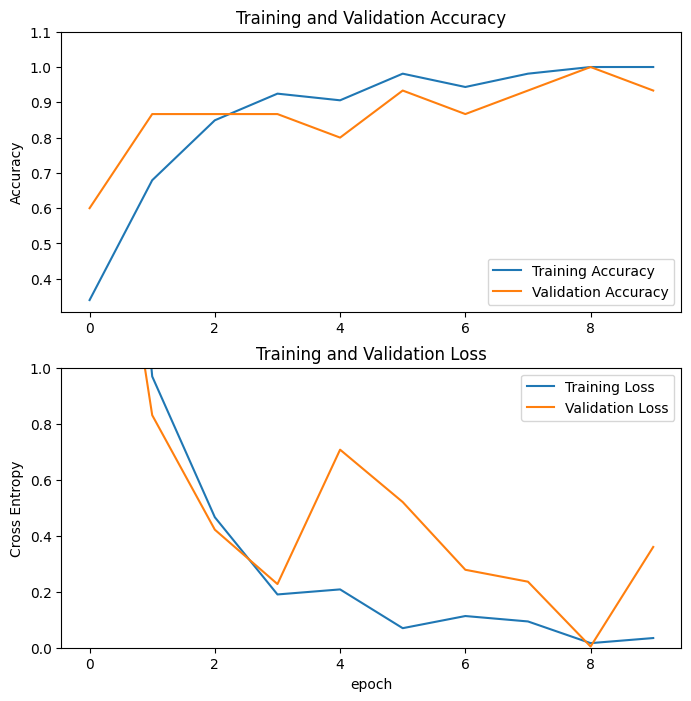

In [ ]:
#results for freezed base model with new classification model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#results on test set
loss, accuracy = model1.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 0s 6ms/step - loss: 0.5548 - accuracy: 0.8571
Test accuracy : 0.8571428656578064


1/1 [==============================] - 0s 170ms/step


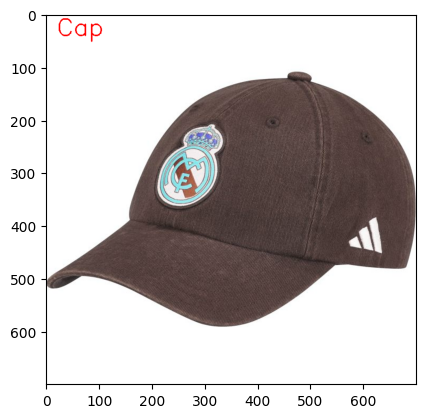

In [ ]:
img=cv2.imread("/cap.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model1.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)

1/1 [==============================] - 0s 20ms/step


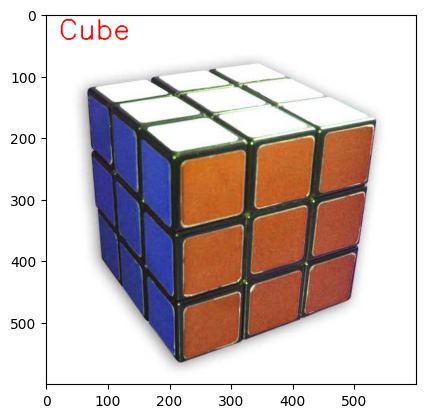

In [ ]:
img=cv2.imread("/cube.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model1.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)

1/1 [==============================] - 0s 20ms/step


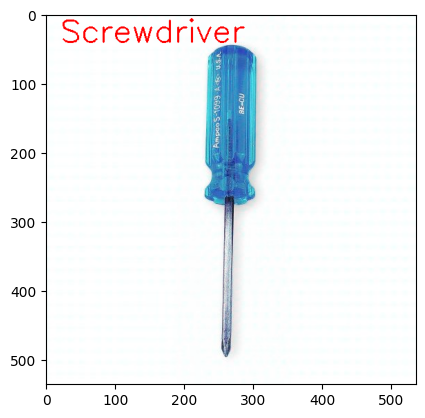

In [ ]:
img=cv2.imread("/screwdriver.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model1.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)

In [ ]:
# Inception V3----------------------------------------------------------------------------------------------------------

In [ ]:
#augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
#pre-processing input
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)
#base model- VGG-19 trained on imagenet
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#taking features from base model
image_batch, label_batch = next(iter(train_dataset))
print(label_batch)
feature_batch = base_model(image_batch)

#freezing the base model
base_model.trainable = False

#Adding Classification model
#pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

#dense layers
class_model=tf.keras.models.Sequential([
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])


#whole model structure
inputs = tf.keras.Input(shape=(227, 227, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = class_model(x)
model2 = tf.keras.Model(inputs, outputs)

tf.Tensor([3], shape=(1,), dtype=int32)


In [ ]:
model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 227, 227, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 227, 227, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 227, 227, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0  

In [ ]:
#compile
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#fit
epochs = 10
history = model2.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/10
53/53 [==============================] - 7s 41ms/step - loss: 1.4425 - accuracy: 0.4528 - val_loss: 0.5403 - val_accuracy: 0.9333
Epoch 2/10
53/53 [==============================] - 1s 16ms/step - loss: 0.2282 - accuracy: 0.9434 - val_loss: 0.1008 - val_accuracy: 1.0000
Epoch 3/10
53/53 [==============================] - 1s 15ms/step - loss: 0.1052 - accuracy: 0.9811 - val_loss: 0.1726 - val_accuracy: 0.9333
Epoch 4/10
53/53 [==============================] - 1s 15ms/step - loss: 0.1372 - accuracy: 0.9623 - val_loss: 0.0683 - val_accuracy: 1.0000
Epoch 5/10
53/53 [==============================] - 1s 15ms/step - loss: 0.0474 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 6/10
53/53 [==============================] - 1s 15ms/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.2885 - val_accuracy: 0.9333
Epoch 7/10
53/53 [==============================] - 1s 15ms/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.1862 - val_accuracy: 0.9333
Epoch 8/10
53

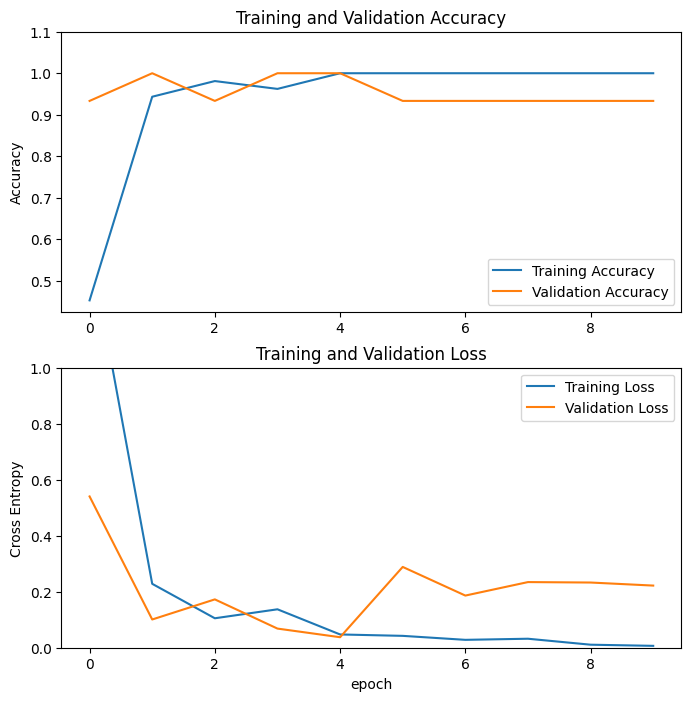

In [ ]:
#results for freezed base model with new classification model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#results on test set
loss, accuracy = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 0s 11ms/step - loss: 0.4158 - accuracy: 0.8571
Test accuracy : 0.8571428656578064


1/1 [==============================] - 1s 1s/step


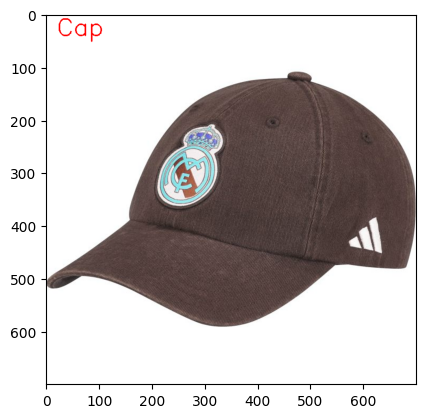

In [ ]:
img=cv2.imread("/cap.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model2.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)

1/1 [==============================] - 0s 27ms/step


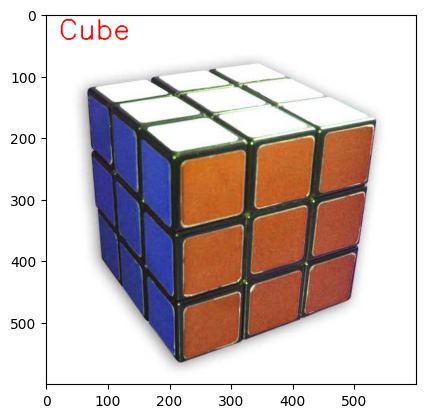

In [ ]:
img=cv2.imread("/cube.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model2.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)

1/1 [==============================] - 0s 26ms/step


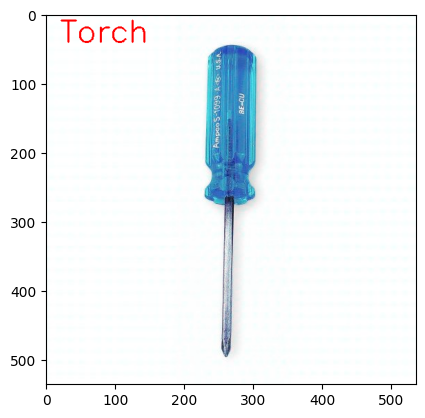

In [ ]:
img=cv2.imread("/screwdriver.jpg")
i1=cv2.resize(img,(227,227)).reshape(1,227,227,3)
res=model2.predict(i1)
cv2.putText(img, class_names[np.argmax(res)].split(' ')[-1], (20,40), 0, 1.5, (255,0,0), 2)
plt.imshow(img)